In [8]:
import torch 
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib as mp
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

## load data
data = pd.read_csv("data.csv")

print(data.count())
data.head()

Date      253
Open      253
High      253
Low       253
Close     253
Volume    253
dtype: int64


,Date,Open,High,Low,Close,Volume
0,05/17/2024,189.51,190.81,189.18,189.87,"41,282,930"
1,05/16/2024,190.47,191.10,189.66,189.84,"52,845,230"
2,05/15/2024,187.91,190.65,187.37,189.72,"70,399,992"
3,05/14/2024,187.51,188.30,186.29,187.43,"52,393,621"
4,05/13/2024,185.44,187.10,184.62,186.28,"72,044,805"


In [9]:
## Prepare the data 
data_selected = data[['Close']].values
train_data, test_data = train_test_split(data_selected, test_size=0.2, shuffle=False)
## Normalize data convert data between -1 and 1
scaler = MinMaxScaler(feature_range=(-1, 1))
train_pr_data = scaler.fit_transform(train_data)
test_pr_data = scaler.fit_transform(test_data)

## convert data to tensor
test_t_data = torch.tensor(test_pr_data, dtype = torch.float32)
train_t_data = torch.tensor(train_pr_data, dtype = torch.float32)

In [10]:
## Generate sequence 

def create_sequence(data, squence_length):
    sequence = []
    targets = []
    for i in range(len(data) - squence_length):
        sequence.append(data[i:i+squence_length])
        targets.append(data[i+squence_length])
    return torch.stack(sequence), torch.stack(targets)


In [11]:
seq_length = 10  # Number of time steps in each sequence
X, y = create_sequence(train_t_data, seq_length)
Xt, yt = create_sequence(test_t_data, seq_length)

In [12]:
class StockLstm(nn.Module):
    def __init__(self, input_size = 1, hidden_size = 50, output_size = 1, num_layers = 1):
        super(StockLstm, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        hO = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        cO = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.lstm(x, (hO, cO))
        out = self.fc(out[:, -1, :])
        return out
    
model = StockLstm()

In [13]:
criteriation  = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

In [14]:
## Train the model

num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    output = model(X)
    optimizer.zero_grad()
    loss = criteriation(output, y)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
        

    

Epoch [10/100], Loss: 0.0725
Epoch [20/100], Loss: 0.0513
Epoch [30/100], Loss: 0.0308
Epoch [40/100], Loss: 0.0269
Epoch [50/100], Loss: 0.0240
Epoch [60/100], Loss: 0.0224
Epoch [70/100], Loss: 0.0217
Epoch [80/100], Loss: 0.0212
Epoch [90/100], Loss: 0.0231
Epoch [100/100], Loss: 0.0214


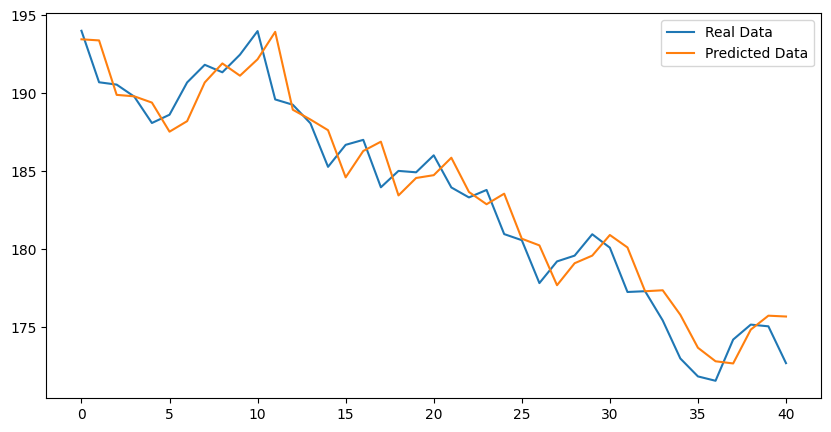

In [15]:
import matplotlib.pyplot as plt
model.eval()
with torch.no_grad():
    predictions = model(Xt).detach().numpy()
    
predictions = scaler.inverse_transform(predictions)
real_data = scaler.inverse_transform(test_t_data[seq_length:])

plt.figure(figsize=(10,5))
plt.plot(real_data, label='Real Data')
plt.plot(predictions, label='Predicted Data')
plt.legend()
plt.show()
